In [12]:
import os
import time
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import style
import plotly.offline as pyoff
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

from HScode import Metrics
import HScode.TrainingCode as trc
import HScode.TestingCode as tec

from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings(action='ignore')
style.use('seaborn-whitegrid')
os.getcwd()

'/Linux/분석 프로젝트/[2021-2022] 초분광 분석(Hyperspectral)/[ 2022 ]/논문 코드 [Prediction]/PSC'

# **1. YP Dataset**

In [13]:
target = "chlorophyll"

In [14]:
data_yp = pd.read_csv("../DAT/complete_data(yang).csv")
data_yp.drop(columns = ["chla"], inplace = True)
data_yp = data_yp.fillna(0)

## **_YP dataset chla(3-5월)**

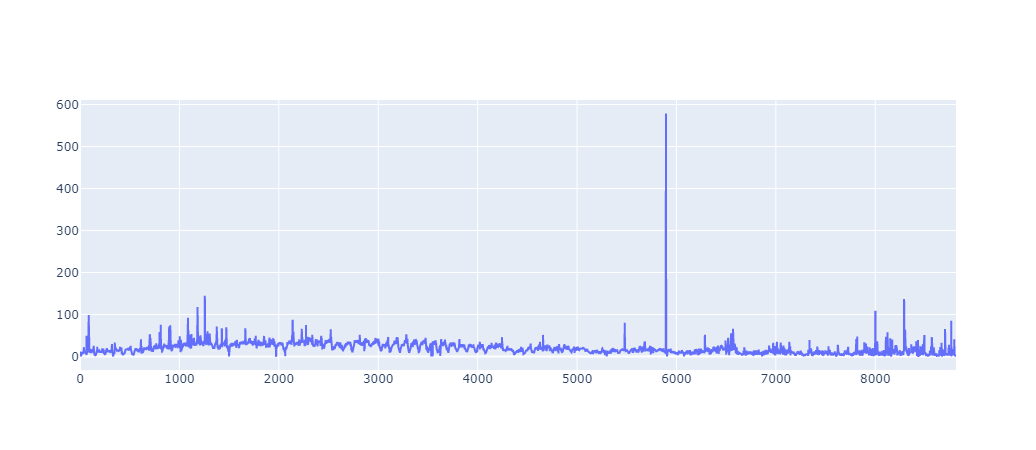

In [15]:
data_yp_35 = data_yp[data_yp["Month"].isin([3,4,5])].reset_index(drop=True)
go.Figure(data = go.Scatter(y = data_yp_35[target], x = data_yp.index, mode='lines'))

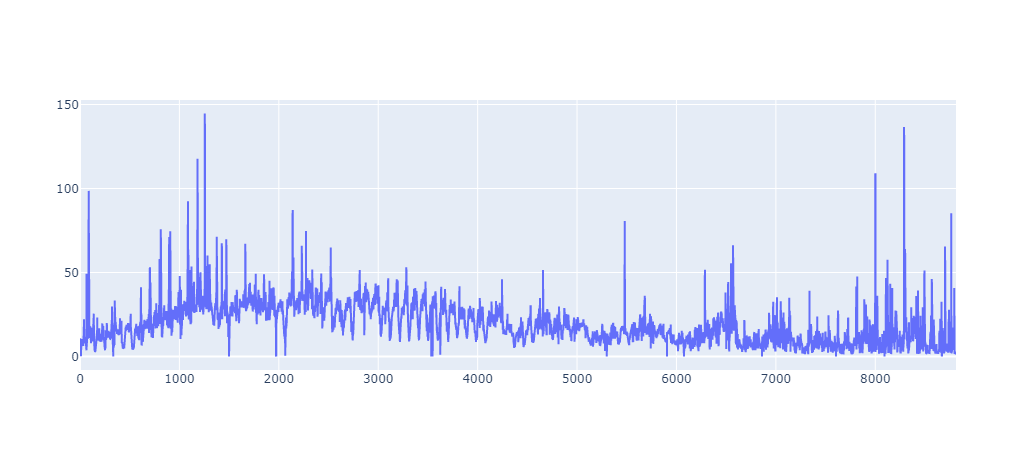

In [16]:
### 이상치 평균으로 대체
data_yp_35 = data_yp[data_yp["Month"].isin([3,4,5])].reset_index(drop=True)
data_yp_35.loc[5893, target] = np.round(data_yp_35.loc[5883:5892, target].mean(), 2)
data_yp_35.loc[5894, target] = np.round(data_yp_35.loc[5884:5893, target].mean(), 2)
go.Figure(data = go.Scatter(y = data_yp_35[target], x = data_yp.index, mode='lines'))

In [17]:
data_yp_train = data_yp_35[data_yp_35["Month"] == 3].reset_index(drop=True)
data_yp_test = data_yp_35[(data_yp_35["Month"] == 4)|(data_yp_35["Month"]==5)].reset_index(drop=True)

print(data_yp_train.shape, data_yp_test.shape)

(2969, 569) (5844, 569)


## **_YP dataset chal(3월)**

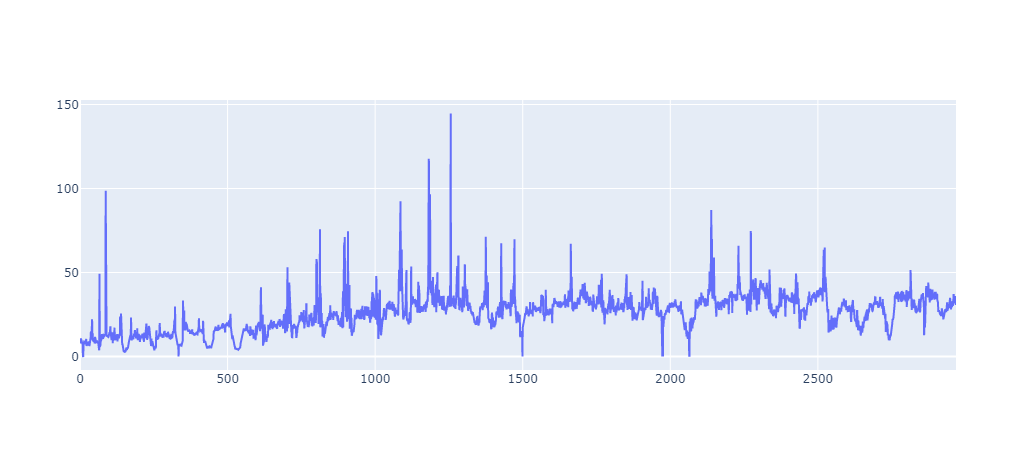

In [18]:
go.Figure(data = go.Scatter(y = data_yp_train[target], x = data_yp.index, mode='lines'))

# **2. PLS 관련 그림**

## **_초분광 변수만 불러오기**

In [19]:
dyt_hs = pd.concat([data_yp_train[target], data_yp_train.filter(regex = "reflectance")], axis = 1)
dyt_hs.head(3)

,chlorophyll,reflectance.000,reflectance.001,reflectance.002,reflectance.003,reflectance.004,reflectance.005,reflectance.006,reflectance.007,reflectance.008,...,reflectance.541,reflectance.542,reflectance.543,reflectance.544,reflectance.545,reflectance.546,reflectance.547,reflectance.548,reflectance.549,reflectance.550
0,9.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **_초분광 변수 Lag dataset**

In [20]:
lag_data = dyt_hs[target]
data = dyt_hs.drop(columns = [target])
for i in range(1, 3+1) : 
    lag = data.shift(i)
    lag.columns = lag.columns + "_lag_" + str(i)
    lag_dyt_hs = pd.concat([lag_data, lag], axis = 1)

lag_dyt_hs = lag_dyt_hs.iloc[3:].reset_index(drop = True)
print(lag_dyt_hs.isnull().sum().sum())
lag_dyt_hs.head()

0


,chlorophyll,reflectance.000_lag_3,reflectance.001_lag_3,reflectance.002_lag_3,reflectance.003_lag_3,reflectance.004_lag_3,reflectance.005_lag_3,reflectance.006_lag_3,reflectance.007_lag_3,reflectance.008_lag_3,...,reflectance.541_lag_3,reflectance.542_lag_3,reflectance.543_lag_3,reflectance.544_lag_3,reflectance.545_lag_3,reflectance.546_lag_3,reflectance.547_lag_3,reflectance.548_lag_3,reflectance.549_lag_3,reflectance.550_lag_3
0,10.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **_초분광 변수 PLS(comp=8)**

In [21]:
std_reflec = StandardScaler().fit(lag_dyt_hs.drop(columns = [target]))
std_reflec_X = pd.DataFrame(std_reflec.transform(lag_dyt_hs.drop(columns = [target])), columns = lag_dyt_hs.drop(columns = [target]).columns).reset_index(drop = True)

y = lag_dyt_hs[target]
std_y = (y - y.mean())/y.std()


### PLS
pls_fit = PLSRegression(n_components = 8).fit(std_reflec_X, std_y)
pls_X = pd.DataFrame(pls_fit.transform(std_reflec_X), columns = ["comp" + str(i+1) for i in range(8)]).reset_index(drop = True)
pls_X.head(3)

,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8
0,-13.447771,0.692479,-0.142978,-0.046874,0.00965,-0.02151,-0.001924,0.009487
1,-13.447771,0.692479,-0.142978,-0.046874,0.00965,-0.02151,-0.001924,0.009487
2,-13.447771,0.692479,-0.142978,-0.046874,0.00965,-0.02151,-0.001924,0.009487


### **__component별 MSE값**

In [22]:
from sklearn.model_selection import RepeatedKFold
from sklearn import model_selection
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
mse = []
n = len(pls_X)

for i in tqdm(np.arange(1, 30+1)) :
    pls = PLSRegression(n_components = i)
    score = -1*model_selection.cross_val_score(pls, std_reflec_X, std_y, cv = cv,
                                               scoring = 'neg_mean_squared_error').mean()
    mse.append(score)

pls_bc = mse.index(min(mse)) + 1     # Best Component

  0%|          | 0/30 [00:00<?, ?it/s]

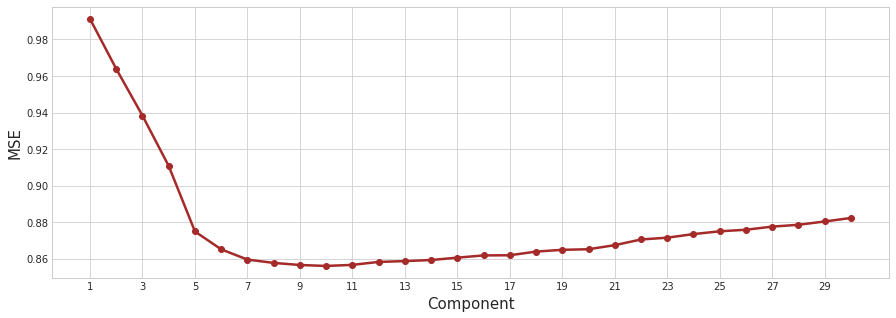

In [23]:
plt.figure(figsize = (15, 5))
plt.plot(mse, color = "brown", linewidth = 2.5, marker = 'o')
plt.xticks(np.arange(0,30,2), np.arange(1,31,2))
plt.ylabel("MSE", fontsize = 15)
plt.xlabel("Component", fontsize = 15);
# plt.title("MSE value of PLS result according to the number of components", fontsize = 15);

In [24]:
display(pd.DataFrame(np.round(mse[:15], 4), index = ["component " + str(i) for i in range(1, 16)], columns = ["MSE"]).T)
display(pd.DataFrame(np.round(mse[15:], 4), index = ["component " + str(i) for i in range(16, 31)], columns = ["MSE"]).T)

,component 1,component 2,component 3,component 4,component 5,component 6,component 7,component 8,component 9,component 10,component 11,component 12,component 13,component 14,component 15
MSE,0.9913,0.9639,0.9383,0.9107,0.8749,0.8651,0.8595,0.8577,0.8565,0.856,0.8566,0.8582,0.8587,0.8593,0.8605


,component 16,component 17,component 18,component 19,component 20,component 21,component 22,component 23,component 24,component 25,component 26,component 27,component 28,component 29,component 30
MSE,0.8618,0.8619,0.8639,0.8648,0.8652,0.8674,0.8705,0.8715,0.8734,0.875,0.8758,0.8775,0.8785,0.8804,0.8823


### **__PLS 전 초분광 변수 그림**

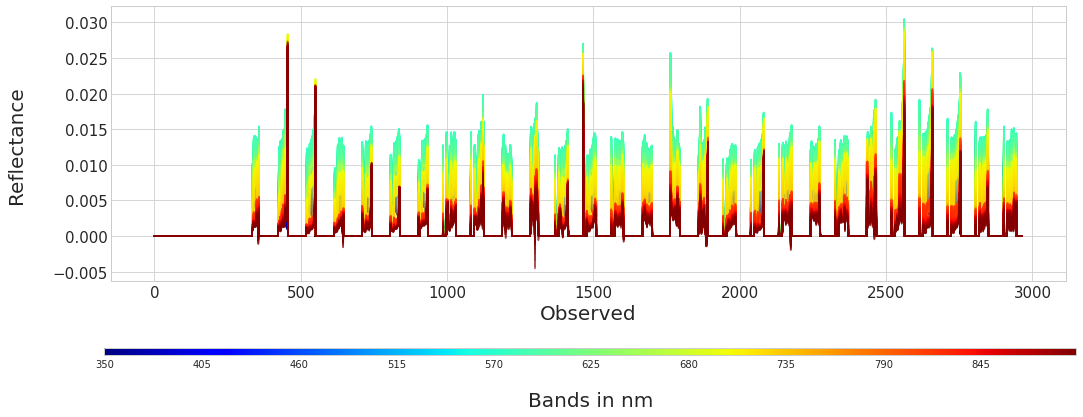

In [25]:
import matplotlib as mpl

hs = lag_dyt_hs.filter(regex = "reflectance")

cmap = plt.get_cmap('jet', 551)

fig = plt.figure(figsize = (15, 5)) 
ax1 = fig.subplots()

ax1.set_xlabel('Observed\n', fontsize = 20)
ax1.set_ylabel('Reflectance\n', fontsize = 20)
for i in range(1, hs.shape[1]) :
    ax1.plot(hs.iloc[:,i], c = cmap(i), alpha = 0.3)
ax1.tick_params(axis = 'y', labelsize = 15) 
ax1.tick_params(axis = 'x', labelsize = 15) 


ax2  = fig.add_axes([0.1, 0.0001, 0.9, 0.02])
norm = mpl.colors.Normalize(vmin = 0, vmax = 2)
cb  = mpl.colorbar.ColorbarBase(ax2, cmap = cmap, orientation = 'horizontal', boundaries = np.arange(350, 900, 1))
cb.set_label('\nBands in nm', labelpad = -0.1, y = 0.02, rotation = 0, fontsize = 20)

plt.tight_layout()
plt.show()

### **__PLS 후 초분광 변수 그림**

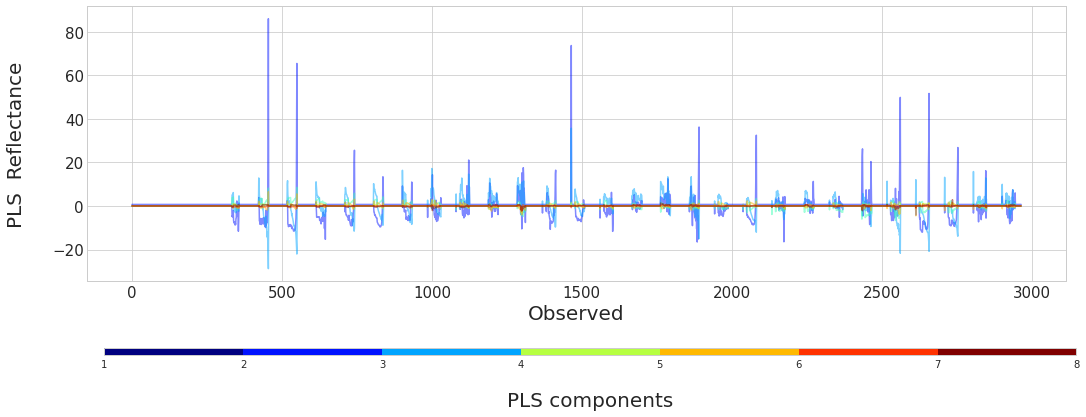

In [26]:
import matplotlib as mpl

hs_pls = pls_X

cmap = plt.get_cmap('jet', 8)

fig = plt.figure(figsize = (15, 5)) 
ax1 = fig.subplots()

ax1.set_xlabel('Observed\n', fontsize = 20)
ax1.set_ylabel('PLS  Reflectance\n', fontsize = 20)
for i in range(1, hs_pls.shape[1]) :
    ax1.plot(hs_pls.iloc[:,i], c = cmap(i), alpha = 0.5)
ax1.tick_params(axis = 'y', labelsize = 15) 
ax1.tick_params(axis = 'x', labelsize = 15) 


ax2  = fig.add_axes([0.1, 0.0001, 0.9, 0.02])
norm = mpl.colors.Normalize(vmin = 0, vmax = 2)
cb  = mpl.colorbar.ColorbarBase(ax2, cmap = cmap, orientation = 'horizontal', boundaries = np.arange(1, 9, 1))
cb.set_label('\nPLS components', labelpad = -0.1, y = 0.02, rotation = 0, fontsize = 20)

plt.tight_layout()
plt.show()

# **3. 예측 결과 그림**

## **_예측 결과 파일 불러오기**

In [121]:
result_df = pd.read_csv("../OUT/paper_result_.csv")
print(result_df.shape)
display(result_df.head(2))

(5843, 11)


,Year,Month,Day,Hour,Min,chlorophyll,Ensemble,RF,XGB,LGB,CNN
0,2022,4,1,0,15,39.91,34.602749,38.0491,36.880287,41.277401,22.204206
1,2022,4,1,0,30,42.24,35.096694,38.2845,35.880066,42.966786,23.255423


In [122]:
### Index 변경 : 날짜가 중간에 비어 이런식으로 생성할 수 밖에 없음
result_df_idx = result_df["Year"].astype(str) + "-" + result_df["Month"].astype(str).str.zfill(2) + "-" + result_df["Day"].astype(str).str.zfill(2) + "-" + result_df["Hour"].astype(str).str.zfill(2) + "-" + result_df["Min"].astype(str).str.zfill(2)
result_df_idx = pd.to_datetime(result2_idx, format = "%Y-%m-%d-%H-%M")
result_df.index = result_df_idx


### Columns 명 변경
result_df.rename(columns = {"RF" : "Random Forest", "XGB" : "XGBoost", "LGB" : "LightGBM", "CNN" : "1D-CNN"}, 
                 inplace = True)


### 새로운 Index 정보와 동일한 "Year, Month, Day, Hour, Min" 변수 제거
result_df.drop(columns = ["Year", "Month", "Day", "Hour", "Min"], inplace = True)


print(result_df.shape)
result_df.head(3)

(5843, 6)


,chlorophyll,Ensemble,Random Forest,XGBoost,LightGBM,1D-CNN
2022-04-01 00:15:00,39.91,34.602749,38.0491,36.880287,41.277401,22.204206
2022-04-01 00:30:00,42.24,35.096694,38.2845,35.880066,42.966786,23.255423
2022-04-01 00:45:00,40.12,36.809404,39.3754,38.902683,45.812632,23.146902


In [143]:
### 예측값 5월 15일까지만 사용 (뒤 쪽은 잘 안맞아서 제외...)
result_df = result_df[(result_df.index < "2022-05-16 00:00:00")]
print(result_df.shape)
display(result_df.head(2))
display(result_df.tail(2))

(4307, 6)


,chlorophyll,Ensemble,Random Forest,XGBoost,LightGBM,1D-CNN
2022-04-01 00:15:00,39.91,34.602749,38.0491,36.880287,41.277401,22.204206
2022-04-01 00:30:00,42.24,35.096694,38.2845,35.880066,42.966786,23.255423


,chlorophyll,Ensemble,Random Forest,XGBoost,LightGBM,1D-CNN
2022-05-15 23:30:00,2.52,7.485190,6.8368,8.560281,9.220075,5.323605
2022-05-15 23:45:00,4.24,7.970338,7.9076,8.512203,9.013507,6.448041


# **_!Index 문제!**

원래 있어야할 테스트 수: 4319 | 실제로 있는 테스트 수: 4307 


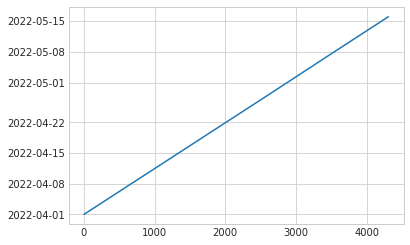

In [146]:
# 중간 중간 비어있는 날짜 존재
origin_date = pd.date_range(start = "202204010015", end = "202205152345", freq = "15min")
print("원래 있어야할 테스트 수: %d | 실제로 있는 테스트 수: %d " % (len(origin_date), len(result_df.index)))

plt.plot(result_df.index);

In [153]:
### 없는 날짜들
non_date = sorted(list(set(origin_date) - set(result_df.index)))
print(len(non_date))
non_date

16


[Timestamp('2022-04-02 02:00:00', freq='15T'),
 Timestamp('2022-04-03 18:45:00', freq='15T'),
 Timestamp('2022-04-13 22:45:00', freq='15T'),
 Timestamp('2022-04-19 08:00:00', freq='15T'),
 Timestamp('2022-04-21 01:30:00', freq='15T'),
 Timestamp('2022-04-21 03:00:00', freq='15T'),
 Timestamp('2022-04-28 03:15:00', freq='15T'),
 Timestamp('2022-04-30 04:30:00', freq='15T'),
 Timestamp('2022-05-01 04:30:00', freq='15T'),
 Timestamp('2022-05-03 04:30:00', freq='15T'),
 Timestamp('2022-05-04 04:30:00', freq='15T'),
 Timestamp('2022-05-04 07:15:00', freq='15T'),
 Timestamp('2022-05-05 04:30:00', freq='15T'),
 Timestamp('2022-05-06 05:00:00', freq='15T'),
 Timestamp('2022-05-09 12:15:00', freq='15T'),
 Timestamp('2022-05-15 19:00:00', freq='15T')]

## **_모든 모델 예측 결과 그림**

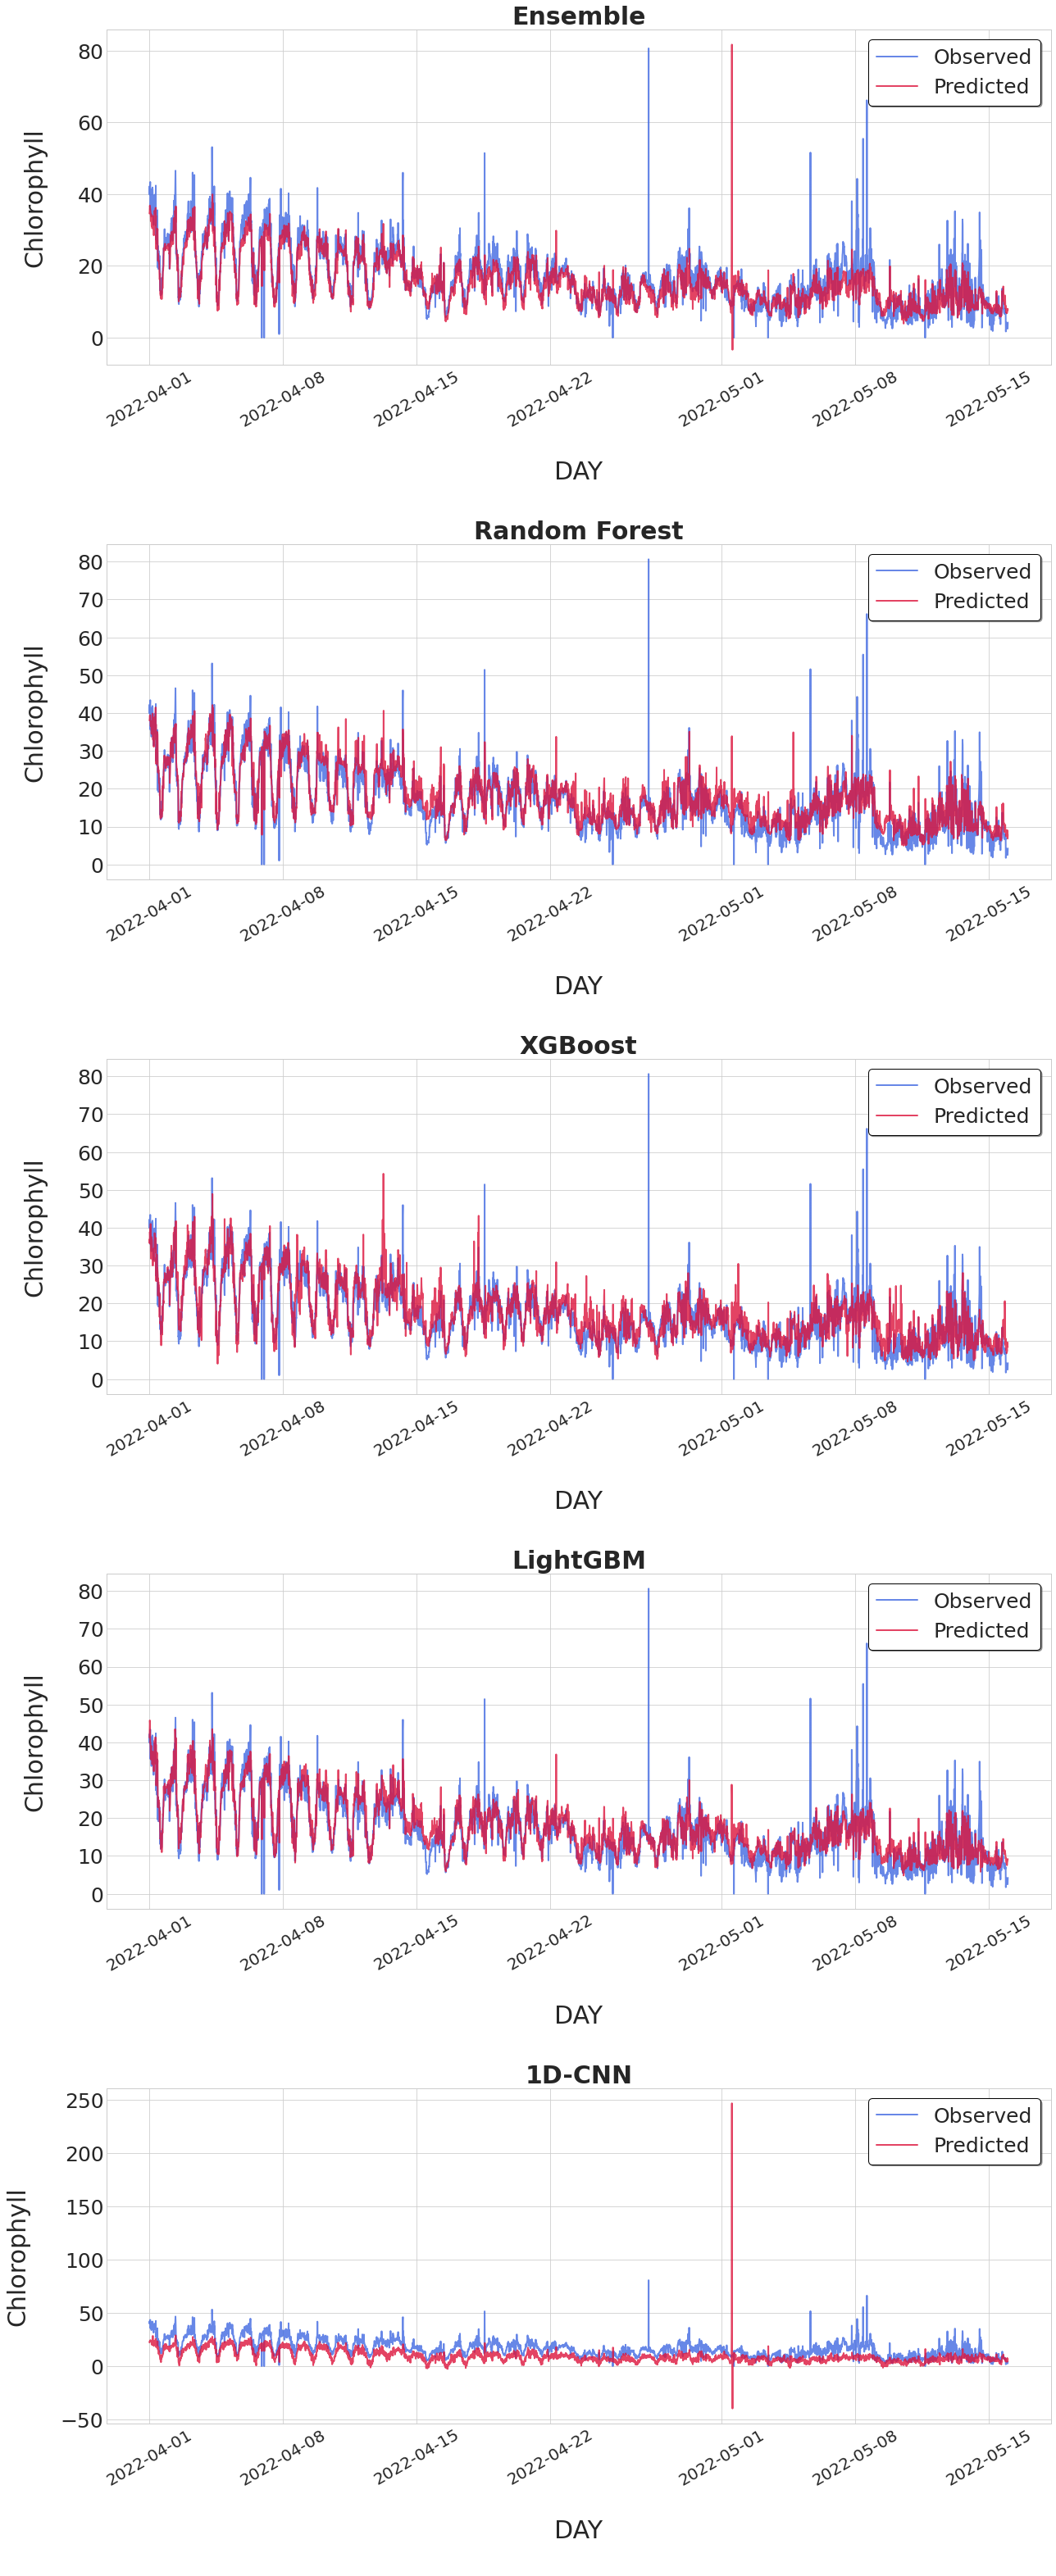

In [152]:
plt.figure(figsize = (18, 50))
model_name = ["Ensemble", "Random Forest", "XGBoost", "LightGBM", "1D-CNN"]
i = 0

for model in model_name : 
    i += 1
    plt.subplot(6, 1, i)
    plt.plot(result_df.loc[:, "chlorophyll"], color = "royalblue", label = "Observed", linewidth = 2, alpha = 0.8)
    plt.plot(result_df.loc[:, model], color = "crimson", label = "Predicted", linewidth = 2, alpha = 0.8)
    
    plt.xticks(fontsize = 20, rotation = 30) ; plt.yticks(fontsize = 25)
    plt.xlabel("\nDAY\n", fontsize = 30) ; plt.ylabel("Chlorophyll\n", fontsize = 30)
    plt.title(model, fontsize = 30, fontweight = "bold")
    plt.legend(loc = "upper right", fontsize = 25, 
               frameon = True, shadow = True, facecolor = "white", edgecolor = "black");

plt.tight_layout();
# plt.savefig('../OUT/Observed vs Predict plot.png', format = 'png', dpi = 200)

In [136]:
### 1D-CNN 예측값 중 튀는 값과 음수로 예측한 값
# display(result_df[result_df["1D-CNN"] == result_df["1D-CNN"].max()])
# display(result_df[result_df["1D-CNN"] < 0])

## **_Observed vs Prediction Plot**

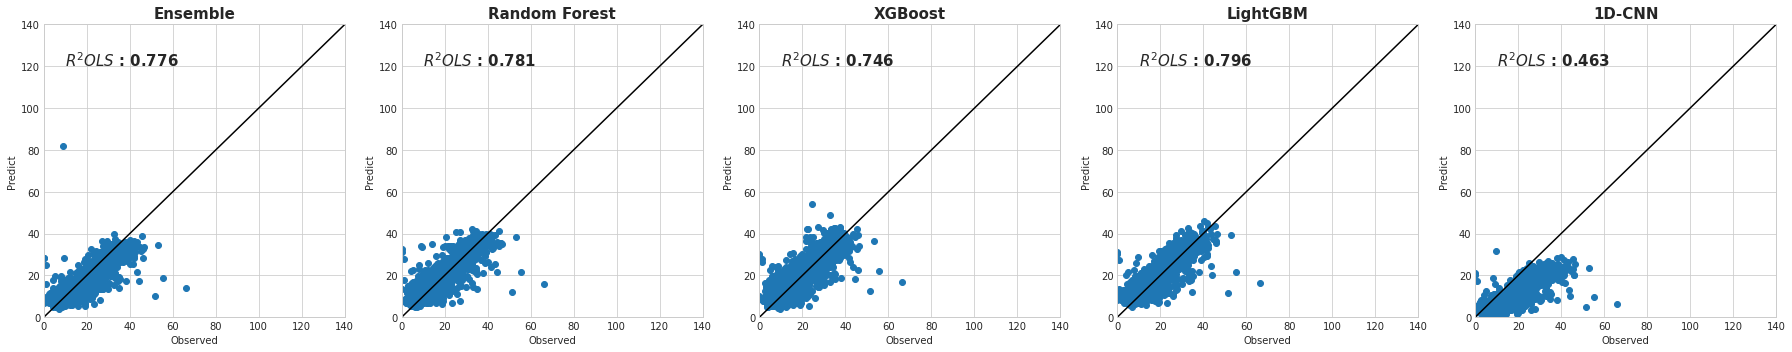

In [30]:
plt.figure(figsize = (25,5))
model_name = ["Ensemble", "Random Forest", "XGBoost", "LightGBM", "1D-CNN"]
i = 0

for model in model_name :
    i += 1
    plt.subplot(1, 5, i)
    plt.scatter(result_df["chlorophyll"], result_df[model])
    plt.plot([0,140], [0,140], color = "black")
    plt.ylim([0,140]); plt.xlim([0,140])
    plt.xlabel("Observed"); plt.ylabel("Predict")
    plt.title(model, fontsize = 15, weight = "bold")
    plt.text(10,120, r"$R^2 OLS$ : " + str(Metrics.R2_OLS(result_df["chlorophyll"], result_df[model])),
             fontsize = 15, weight = "bold")

plt.tight_layout();

# **4. R square plot**

## **_R2 결과 데이터 불러오기**

In [137]:
r2s = pd.read_csv("../OUT/R square result.csv").iloc[:,1:]

### Index and Columns 변경
r2s.rename(columns = {"ensemble" : "Ensemble", "RF" : "Random Forest", "XGB" : "XGBoost", "LGB" : "LightGBM", "CNN" : "1D-CNN"}, 
           inplace = True)
date_idx = pd.date_range(start = "20220401", end = "20220531", freq = "D")
print(date_idx[:3], "||", date_idx[-3:])
r2s.index = date_idx

r2s.head(3)

DatetimeIndex(['2022-04-01', '2022-04-02', '2022-04-03'], dtype='datetime64[ns]', freq='D') || DatetimeIndex(['2022-05-29', '2022-05-30', '2022-05-31'], dtype='datetime64[ns]', freq='D')


,Ensemble,Random Forest,XGBoost,LightGBM,1D-CNN
2022-04-01,0.987553,0.987226,0.983342,0.986275,0.979822
2022-04-02,0.986209,0.986043,0.976290,0.986152,0.977389
2022-04-03,0.985874,0.982853,0.977827,0.986459,0.978449


In [138]:
### 5월 15일 예측값까지의 R2 호출
r2s2 = r2s[r2s.index <= "2022-05-15"]
r2s2.head(3)

,Ensemble,Random Forest,XGBoost,LightGBM,1D-CNN
2022-04-01,0.987553,0.987226,0.983342,0.986275,0.979822
2022-04-02,0.986209,0.986043,0.976290,0.986152,0.977389
2022-04-03,0.985874,0.982853,0.977827,0.986459,0.978449


## **_R2 plot ver1**

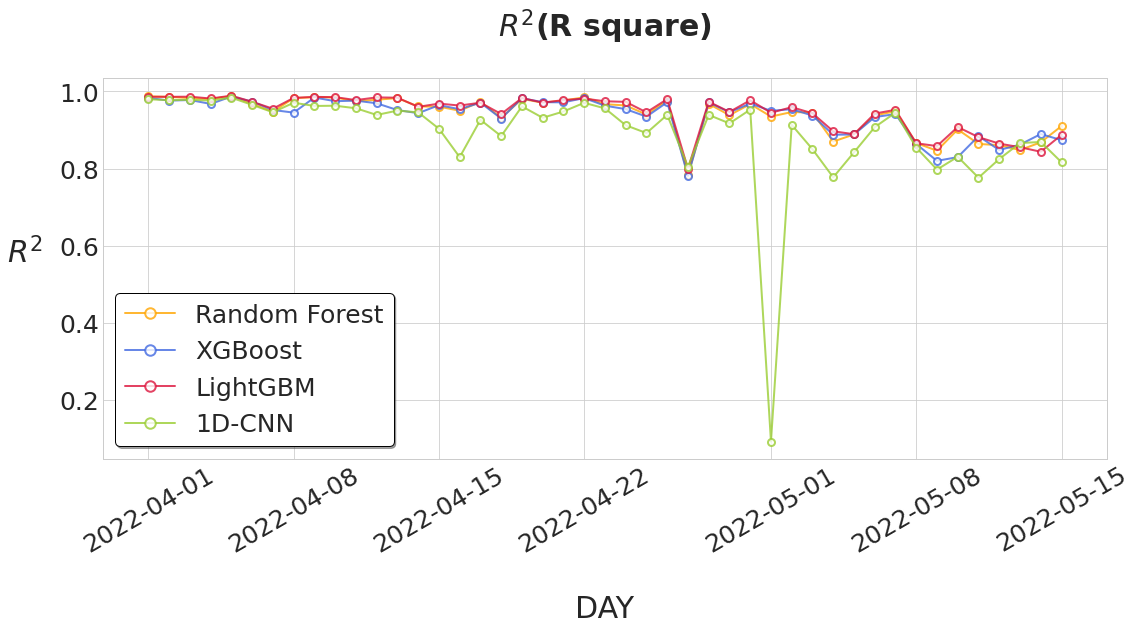

In [139]:
plt.style.use('seaborn-whitegrid')
# plt.style.available
plt.figure(figsize = (18, 7))

colors = ["lightcoral", "orange", "royalblue", "crimson", "yellowgreen"]

for i in range(1,5) :
    plt.plot(r2s2.iloc[:, i], label = r2s2.columns[i], 
             linewidth = 2, alpha = 0.8, color = colors[i],
             marker = "o", markersize = 7, markerfacecolor = "white", markeredgecolor = colors[i], markeredgewidth = 2)
    
    plt.xticks(fontsize = 25, rotation = 30); plt.yticks(fontsize = 25)
    plt.xlabel("\nDAY", fontsize = 30); plt.ylabel(r"$R^2$       ", fontsize = 30, rotation = 0)
    plt.title(r"$R^2$" + "(R square)\n", fontsize = 30, fontweight = "bold")
    
plt.legend(loc = "lower left", fontsize = 25, markerscale = 1.5,
           frameon = True, shadow = True, facecolor = "white", edgecolor = "black");

plt.savefig('../OUT/R2 plot - ver1.png', format = 'png', dpi = 200)

## **_R2 plot ver2**

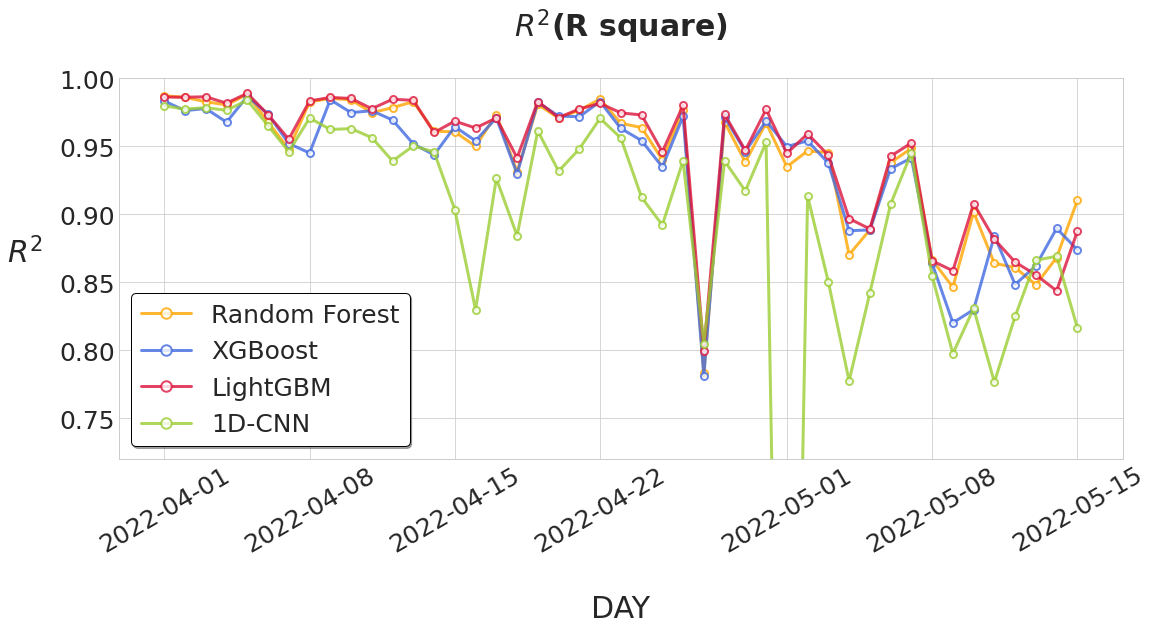

In [140]:
plt.figure(figsize = (18, 7))

for i in range(1, 5) :
    plt.plot(r2s2.iloc[:, i], label = r2s2.columns[i], 
             linewidth = 3, alpha = 0.8, color = colors[i],
             marker = "o", markersize = 7, markerfacecolor = "white", markeredgecolor = colors[i], markeredgewidth = 2)
    
    plt.xticks(fontsize = 25, rotation = 30); plt.yticks(fontsize = 25)
    plt.xlabel("\nDAY", fontsize = 30); plt.ylabel(r"$R^2$       ", fontsize = 30, rotation = 0)
    plt.title(r"$R^2$" + "(R square)\n", fontsize = 30, fontweight = "bold")
    plt.ylim(0.72, 1)
    
plt.legend(loc = "lower left", fontsize = 25, markerscale = 1.5,
           frameon = True, shadow = True, facecolor = "white", edgecolor = "black");

plt.savefig('../OUT/R2 plot - ver2.png', format = 'png', dpi = 200)

## **_R2 table**

In [142]:
pd.DataFrame([np.round(r2s2.min(axis = 0), 3),
              np.round(r2s2.mean(axis = 0), 3),
              np.round(r2s2.max(axis = 0), 3)],
             index = ["MIN", "MEAN", "MAX"]).T

,MIN,MEAN,MAX
Ensemble,0.736,0.941,0.990
Random Forest,0.783,0.941,0.988
XGBoost,0.781,0.937,0.987
LightGBM,0.799,0.945,0.989
1D-CNN,0.092,0.892,0.984


# **5. Variable Importance - LightGBM**

## **_LGB VI 데이터 불러오기**

In [154]:
vi_lgb = pd.read_csv("../OUT/VI_lgb.csv")
print(vi_lgb.shape)
display(vi_lgb.head(3))

(61, 28)


,conductivity_lag_1,do_lag_1,ph_lag_1,phycocyanin_lag_1,turbidity_lag_1,waterDepth_lag_1,waterTemperature_lag_1,airTemperature_lag_1,humidity_lag_1,insolation_lag_1,...,comp7,comp8,spring,summer,fall,winter,morning,afternoon,evening,non-hs
0,43,242,160,476,229,100,202,174,311,267,...,45,34,0,0,0,0,1,11,0,10
1,37,251,163,447,272,129,212,182,260,254,...,45,35,0,0,0,0,1,9,2,14
2,39,229,175,425,261,128,243,169,308,247,...,56,33,0,0,0,0,1,9,4,6


In [156]:
### Index 변경
vi_lgb.index = pd.date_range(start = "20220401", end = "20220531", freq = "D")
display(vi_lgb.tail(3))

### 5월 15일까지만 불러오기
vi_lgb515 = vi_lgb[vi_lgb.index <= "2022-05-15"]
display(vi_lgb515.tail(3))

,conductivity_lag_1,do_lag_1,ph_lag_1,phycocyanin_lag_1,turbidity_lag_1,waterDepth_lag_1,waterTemperature_lag_1,airTemperature_lag_1,humidity_lag_1,insolation_lag_1,...,comp7,comp8,spring,summer,fall,winter,morning,afternoon,evening,non-hs
2022-05-29,37,200,186,452,222,134,374,145,196,263,...,100,48,0,0,0,0,2,11,2,10
2022-05-30,39,196,200,446,243,145,328,143,204,246,...,70,65,0,0,0,0,1,13,1,6
2022-05-31,40,189,192,427,210,139,369,159,226,252,...,60,71,0,0,0,0,6,9,2,7


,conductivity_lag_1,do_lag_1,ph_lag_1,phycocyanin_lag_1,turbidity_lag_1,waterDepth_lag_1,waterTemperature_lag_1,airTemperature_lag_1,humidity_lag_1,insolation_lag_1,...,comp7,comp8,spring,summer,fall,winter,morning,afternoon,evening,non-hs
2022-05-13,46,234,228,480,222,156,317,160,246,262,...,61,35,0,0,0,0,3,6,3,11
2022-05-14,38,238,224,461,234,176,343,156,242,276,...,36,41,0,0,0,0,5,12,1,7
2022-05-15,43,229,235,473,247,168,315,167,217,276,...,60,31,0,0,0,0,2,6,4,7


## **_LGB VI Box plot**

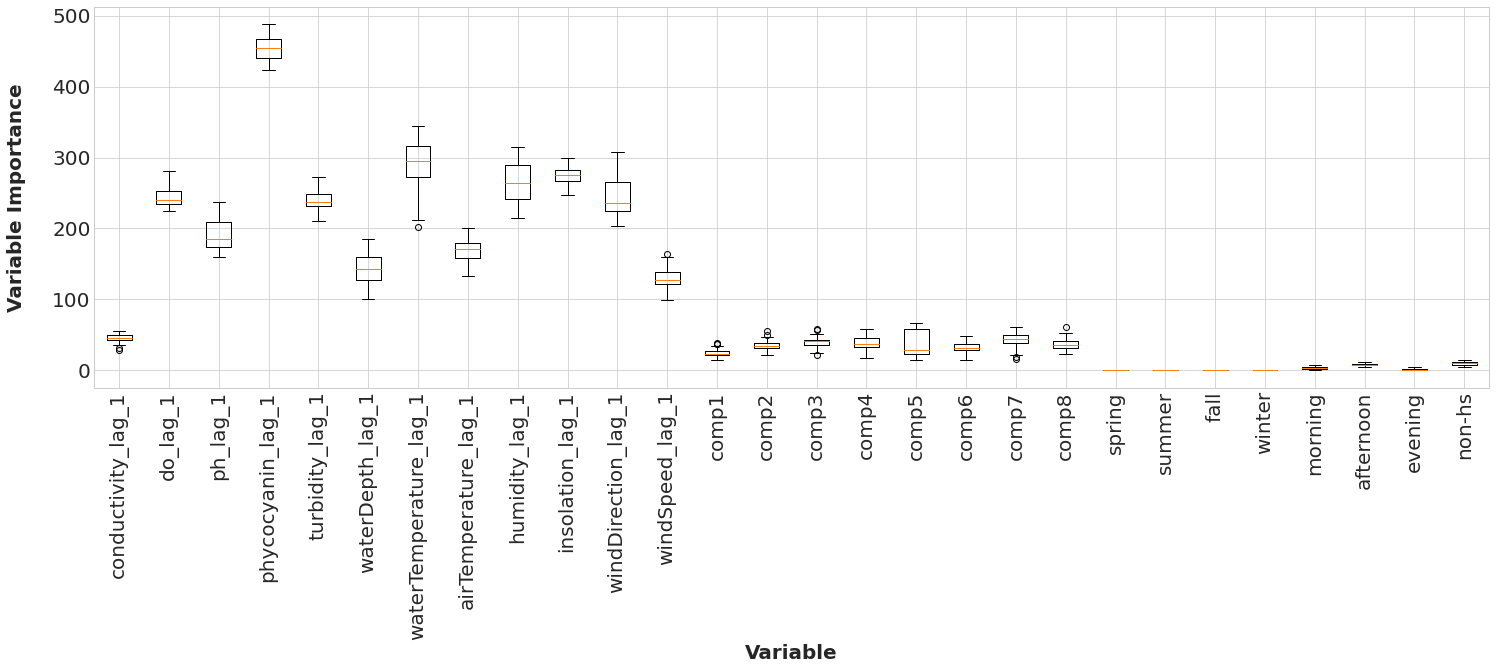

In [158]:
plt.figure(figsize = (25, 7))
plt.boxplot(vi_lgb515)
plt.yticks(fontsize = 20)
plt.xticks(range(1, 29), vi_lgb515.columns, rotation = 90, fontsize = 20)
plt.xlabel("Variable", fontsize = 20, weight = "bold")
plt.ylabel("Variable Importance\n", fontsize = 20, weight = "bold");

## **_LGB VI line plot**

In [ ]:
plt.style.use('seaborn-whitegrid')
# plt.style.available
plt.figure(figsize = (20, 7))

# colors = ["lightcoral", "orange", "royalblue", "crimson", "yellowgreen"]
colors = [plt.cm.Spectral(i) for i in np.linspace(0, 1, 28)]

for i in range(vi_lgb515.shape[1]) :
    plt.plot(vi_lgb515.iloc[:, i], label = vi_lgb_df2.columns[i], 
             linewidth = 2, alpha = 0.8, color = colors[i],
             marker = "o", markersize = 7, markerfacecolor = "white", markeredgecolor = colors[i], markeredgewidth = 2)
    
    plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
    plt.xlabel("DAY", fontsize = 20, weight = "bold")
    plt.ylabel("Variable Importance\n", fontsize = 20, weight = "bold")
    
plt.legend(loc = (1.01, 0.1), ncol = 2, fontsize = 13, markerscale = 1,
           frameon = True, shadow = True, facecolor = "white", edgecolor = "black");